In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

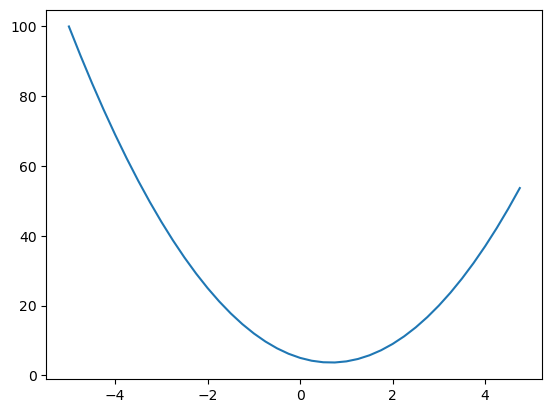

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# What does a deriviate do?
# Rate of change at point x with the increament with h
h= 0.0000001
x = 2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [6]:
# More complex example

a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [7]:
h=0.00001

# inputs
a=2.0
b=-3.0
c=10.0

# operations
d1 = a*b+c
a += h
d2 = a*b+c

print('d1: ',d1)
print('d2: ',d2)
print('slope: ', (d2 - d1)/h)
print("Remark:\n d2 is less than d1 means that slope has decreased so the dericative of d2 w.r.t a is negative \n meaning change in a changes d1 -vely")

d1:  4.0
d2:  3.9999699999999994
slope:  -3.000000000064062
Remark:
 d2 is less than d1 means that slope has decreased so the dericative of d2 w.r.t a is negative 
 meaning change in a changes d1 -vely


In [8]:
# Here _children keeps track of children data,  _op keeps track of operation, grad: dervivative of 'L' w.r.t each node
class Value:
    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev= set(_children)
        self._op= _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return -1 * self
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), '''only support for int and float'''
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward
        
        return out
    
   
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += (math.exp(x)) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
    
a= Value(2.0, label='a')
b= Value(-3.0, label='b')
c= Value(10.0, label='c')
e= a*b; e.label='e'
d= e+c; d.label='d'
f= Value(-2.0, label='f')
L = d*f; L.label='L'
d

Value(data=4.0)

In [9]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [10]:
print(d._prev)
print("Where -6 is a*b and 10 is c, it mainly shows the data involved in operation \n internally: ((a)__mul__(b)) __add__(c)")



{Value(data=10.0), Value(data=-6.0)}
Where -6 is a*b and 10 is c, it mainly shows the data involved in operation 
 internally: ((a)__mul__(b)) __add__(c)


In [11]:
print(d._op)
print("Show the operation tht took place at the end")

+
Show the operation tht took place at the end


In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f| grad %.4f }" % ( n.label,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

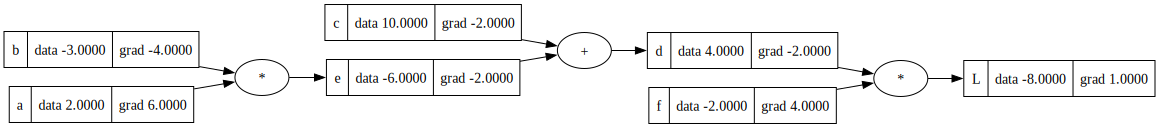

In [13]:
L.backward()

draw_dot(L)


Derivative of L with respect to d:

L = d*f

dL/dd: ?

(f(x+h)-f(x))/h

= ((d+h)*f - d*f)/h
= (df + hf - df)/h
= hf/h
= f

In [14]:
# Manually defining the gradients

# L.grad = 1.0
# f.grad = 4.0
# d.grad = -2.0
# e.grad = -2.0
# c.grad = -2.0
# a.grad = 6.0
# b.grad = -4.0

In [15]:
# Checking the gradients

def lol():
    a= Value(2.0, label='a')
    b= Value(-3.0, label='b')
    c= Value(10.0, label='c')
    e= a*b; e.label='e'
    d= e+c; d.label='d'
    f= Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    h= 0.0001
    
    a= Value(2.0+h, label='a')
    b= Value(-3.0, label='b')
    c= Value(10.0, label='c')
    e= a*b; e.label='e'
    d= e+c; d.label='d'
    f= Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

6.000000000021544


<!-- Activation Function  -->
<!--  Squashing the input into the range of -1 to 1 and displaying-->

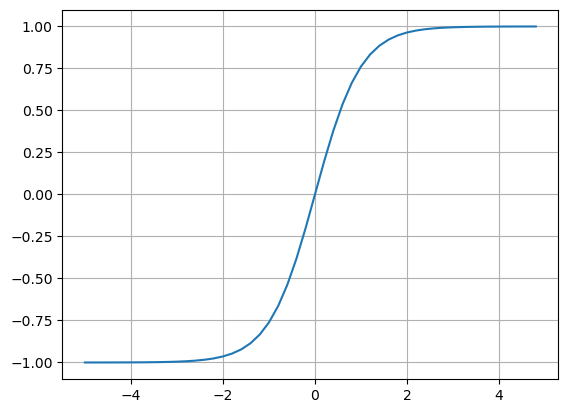

In [16]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [17]:
# Using tanh to build a network

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

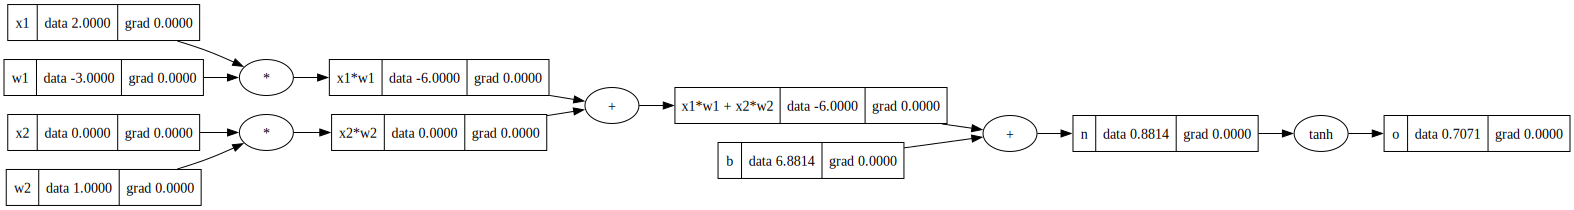

In [18]:

draw_dot(o)

In [19]:
o.backward()

In [20]:
# Using tanh to build a network

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label='e'
o = (e-1)/(e+1); o.label = 'o'


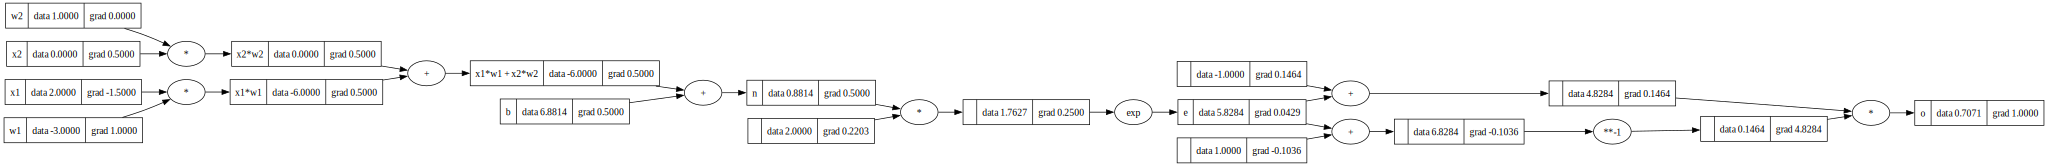

In [21]:
o.backward()
draw_dot(o)

In [22]:
# Manual Calling
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [23]:
# Manual Calling
# o.grad=1.0
# n.grad = (1-o.data**2)
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# # x2.grad = w2.data * x2w2.grad
# x2.grad = 0.5*w2.data 
# w2.grad = 0.5*x2.data

# # x1.grad = w1.data * x1w1.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

o = tanh(n)
so, 
    do/dn = d(tanh(n))/dn
          = 1 - tanh(n)**2
          = 1 - o**2

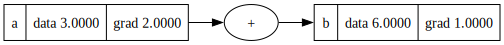

In [24]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

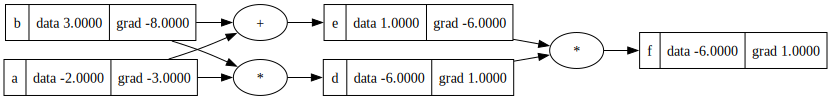

In [25]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [26]:
import torch
import random

In [27]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


<!-- For Neuron -->

In [82]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [85]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.35678466100851297)

In [87]:
n.parameters() #all the loads and biases 

[Value(data=-0.018807676555554043),
 Value(data=-0.6168847014126804),
 Value(data=-0.5884242493960523),
 Value(data=0.043190504409632346),
 Value(data=-0.7605493532688143),
 Value(data=-0.6961373065512049),
 Value(data=-0.6315807821080344),
 Value(data=-0.6388965690141639),
 Value(data=-0.14253962500476236),
 Value(data=0.35282683858292296),
 Value(data=0.9133828654531069),
 Value(data=0.7088771820712727),
 Value(data=0.44324430030690243),
 Value(data=-0.6536776582828814),
 Value(data=0.48160716928281255),
 Value(data=0.20669155837212116),
 Value(data=0.030230760953050106),
 Value(data=0.3961136326773125),
 Value(data=-0.10485292346604846),
 Value(data=0.34862991478114247),
 Value(data=-0.9033495548566806),
 Value(data=-0.9217537182674325),
 Value(data=0.5324737241391082),
 Value(data=-0.15209606226386674),
 Value(data=0.37677949335740424),
 Value(data=0.24759563063780887),
 Value(data=0.2254576176645564),
 Value(data=-0.399774537127527),
 Value(data=-0.1212548002762801),
 Value(data=0

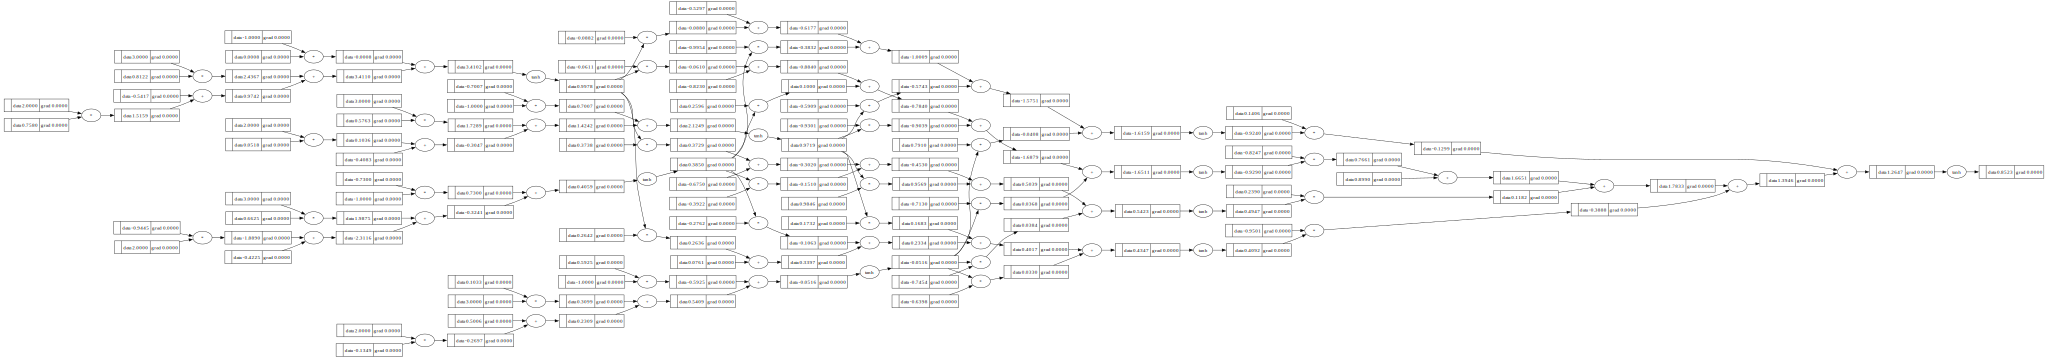

In [56]:
draw_dot(n(x))

In [103]:
# Making prediction (classifier)

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]



In [94]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.35678466100851297),
 Value(data=0.11448942286151077),
 Value(data=0.5133213792373041),
 Value(data=0.05391153213133115)]

In [89]:
loss=sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.841037631874899)

In [90]:
loss.backward()

In [91]:
n.layers[0].neurons[0].w[0].grad

-1.811140272816026

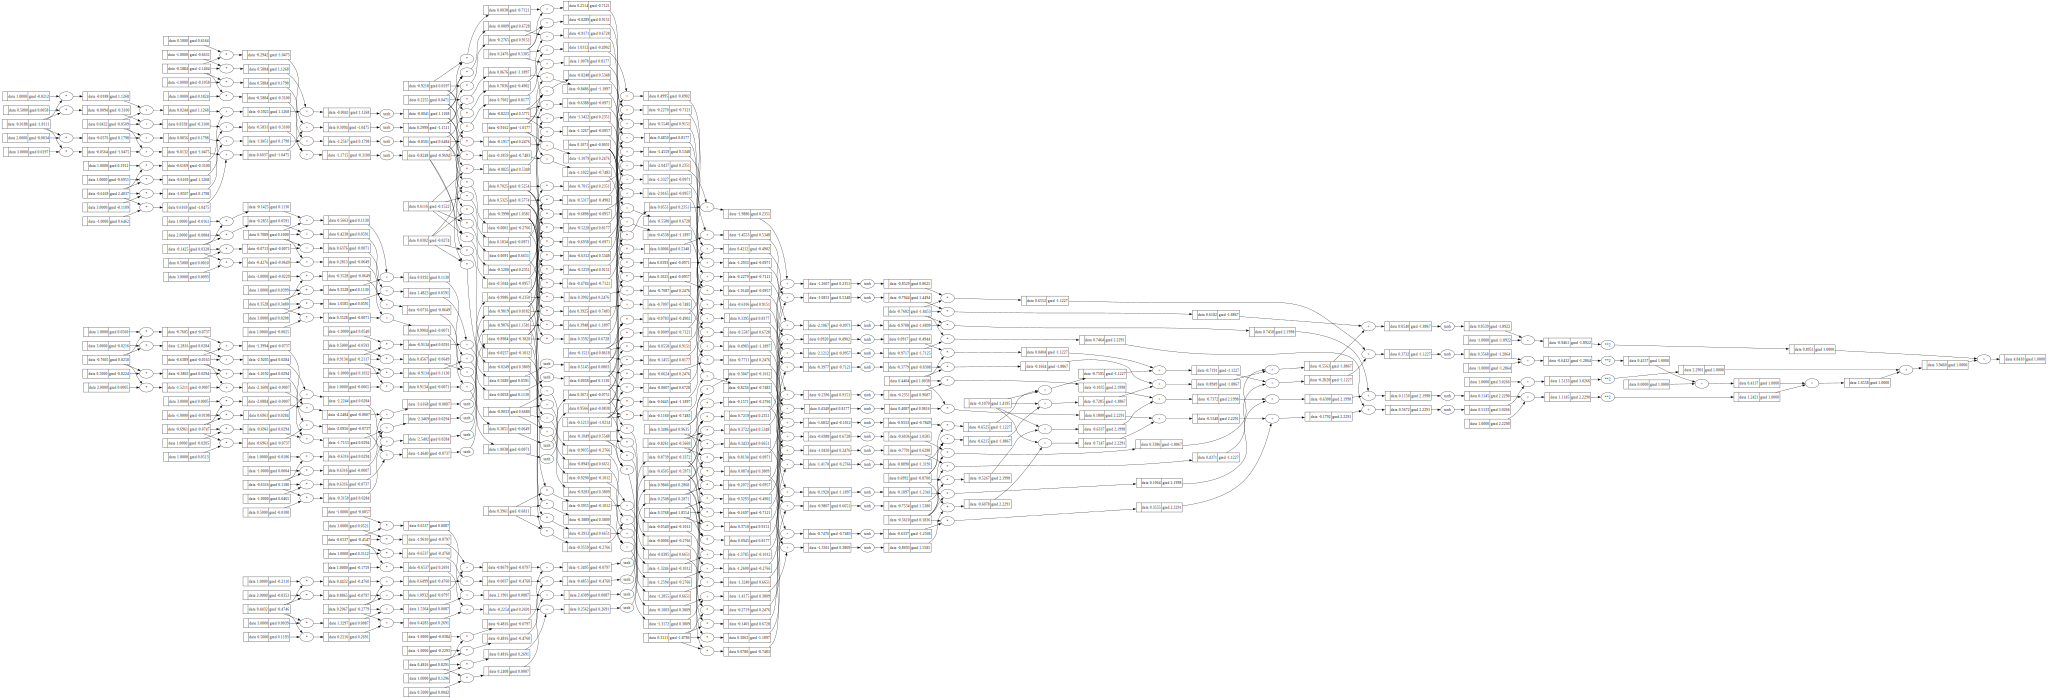

In [92]:
draw_dot(loss)

In [102]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.8099705200106345)

In [104]:
for k in range(20):
#     Forward Pass
    ypred = [n(x) for x in xs]
    loss=sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
#  Backward Pass  
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

#     Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 4.65955414233138
1 2.406252983120823
2 1.7663876097474533
3 1.2295156395943705
4 0.5112226308637936
5 0.27538446400538286
6 0.22354699730236055
7 0.188584150261925
8 0.1622756012895345
9 0.1417557625226689
10 0.1253681289788916
11 0.11202982117855051
12 0.10099806790521534
13 0.09174731754807743
14 0.08389639500756431
15 0.07716293369538445
16 0.07133385343373769
17 0.06624569742101925
18 0.06177122237543907
19 0.057810060342120335


In [105]:
ypred

[Value(data=0.8993754104482151),
 Value(data=-0.9434872069803604),
 Value(data=-0.8337739022309177),
 Value(data=0.8701541646211245)]